In [47]:
import numpy as np              
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd            
import seaborn as sns           
import sklearn     
sns.set_theme()
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Постановка задачи
Предоставлены данные, собранные в рамках рекламной кампании некоего португальского банка, по результатам обзвона клиентов с предложением сделать срочный вклад. Предлагается по данным, доступным о клиенте до рекламного звонка предсказать, будет ли он готов сделать этот вклад. Источник данных: https://www.kaggle.com/kidoen/bank-customers-data

# Предобработка данных

## 1. Чтение данных

In [2]:
url = "https://raw.githubusercontent.com/mezotaken/ML-Course/master/BankCustomerData.csv"
data_raw = pd.read_csv(url)

In [3]:
data_raw.shape

(42639, 17)

In [4]:

data_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
data_raw.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,term_deposit
42634,21,student,single,secondary,no,2488,no,no,telephone,12,jan,661,2,92,1,success,yes
42635,87,retired,married,primary,no,2190,no,no,telephone,12,jan,512,2,-1,0,unknown,yes
42636,34,blue-collar,married,primary,no,6718,no,no,cellular,13,jan,278,4,97,1,other,no
42637,22,student,single,secondary,no,254,no,no,cellular,13,jan,143,2,-1,0,unknown,yes
42638,32,management,single,tertiary,no,1962,no,no,cellular,13,jan,130,1,-1,0,unknown,no


Итак, таблица содержит данные о 42.6 тыс. клиентах банка и контакте с ними. Всего имеется 17 признаков:

Очевидные:
- `age` 
- `job`
- `marital`
- `education`
- `balance`

Требующие разъяснения:
- `default` - есть ли задолженность на кредитной карте
- `housing` - есть ли ипотечный кредит
- `loan` - есть ли кредит на личные цели
- `contact` - куда был произведён рекламный звонок
- `day/month` - день/месяц рекламного звонка
- `duration` - длительность звонка (Примечание: данный признак имеет прямое влияние на цель предсказания, нулевые по длительности разговоры автоматически означают отказ. При обучении модели его необходимо отбросить. )
- `campaign` - число звонков данному клиенту в рамках текущей рекламной кампании
- `pdays` - число дней со звонка по прошлой рекламной кампании (-1 если звонка по ней не было)
- `previous`- число звонков данному клиенту в рамках прошлой рекламной кампании
- `poutcome` - результат прошлой рекламной кампании 

Преобразуем тип соответствующих категориальных признаков в подходящий и рассмотрим индексы каждой категории:

In [6]:
for col in ['job', 'marital', 'education', 'default','housing', 'loan', 'contact', 'month','poutcome','term_deposit']:
    data_raw[col] = data_raw[col].astype('category')
    print(col)
    print(data_raw[col].dtype.categories)
    print('-------------------------------')

job
Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'],
      dtype='object')
-------------------------------
marital
Index(['divorced', 'married', 'single'], dtype='object')
-------------------------------
education
Index(['primary', 'secondary', 'tertiary', 'unknown'], dtype='object')
-------------------------------
default
Index(['no', 'yes'], dtype='object')
-------------------------------
housing
Index(['no', 'yes'], dtype='object')
-------------------------------
loan
Index(['no', 'yes'], dtype='object')
-------------------------------
contact
Index(['cellular', 'telephone', 'unknown'], dtype='object')
-------------------------------
month
Index(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov',
       'oct', 'sep'],
      dtype='object')
-------------------------------
poutcome
Index(['failure', 'other', 'success', 'unknown'], dtype=

Опять же, всё очевидно, кроме, разве что, индекса 'other' в исходе предыдущей рекламной кампании. Возможно так обозначался исход, когда клиента не удавалось уговорить на вклад, но получалось на что-то ещё? В описании к данным это упущено.

Также возникает вопрос, как поступать с индексами 'unknown'. По своей сути это пропущенные значения, очевидно, что признаки 'job', 'education', 'contact' мы можем обработать по стандартному сценарию, но можно ли так же поступить с признаком 'poutcome'? Ведь скорее всего согласие/несогласие в прошлую кампанию должно коррелировать с текущим согласием/несогласием, а если предложения не было вовсе, то никакой связи с будущим результатом установить нельзя, то есть замена на моду (несогласие, отказ клиента) будет занижать вероятность на успех без какого-либо значительного повода? Вероятно, чтобы это понять, стоит провести эксперимент с заменой и без замены и посмотреть на ложноотрицательные ошибки в каждом случае.

UPD: Оставляем unknown для категории poutcome.

## 2. Обработка выбросов
Из всех числовых признаков только возраст и баланс счёта могут обладать выбросами, построим диаграмму рассеивания"

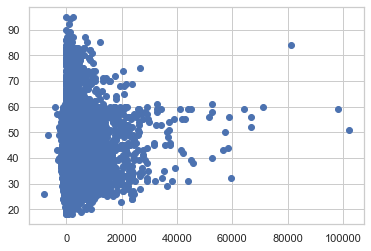

In [42]:
plt.scatter(data_raw['balance'],data_raw['age'])

Видим, что выбросы есть для баланса, уберём 0.1% граничных данных для баланса и построим диаграмму рассеивания заново:

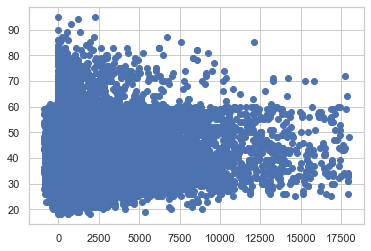

In [43]:
rows_to_drop = data_raw[
    (data_raw['balance'] < data_raw['balance'].quantile(0.005)) | (data_raw['balance'] > data_raw['balance'].quantile(0.995))].index
data = data_raw.drop(rows_to_drop)
data.shape
plt.scatter(data['balance'],data['age'])

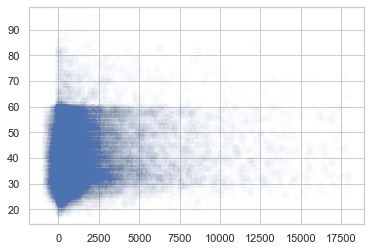

In [44]:
plt.scatter(data['balance'],data['age'],alpha=0.01)

Какой-либо зависимости между возрастом и балансом на счёте проследить не удаётся, хотя поначалу кажется что у людей 60 лет и старше в среднем меньше денег на счёте, но на самом деле им звонили в целом намного реже, что видно на прозрачной диаграмме.

Также здесь видна довольно занятная аномалия, ни у одного клиента старше 60 лет нет отрицательного баланса на счёте. Я честно попытался найти какой-то ответ в законодательстве Португалии о пенсионном возрасте, но никакого разумного естественного объяснения не нашёл. Есть вариант, что это влияние самого процесса обзвона, то есть людям старше 60 с задолженностью на счёте попросту не звонили, что объясняет эту искусственную границу на диаграмме.

Также заменим значение "-1" для дней, прошедших с последнего звонка, (то есть ситуации когда звонка не было вообще) большим значением, например в год:

In [10]:
data.loc[data['pdays'] == -1, 'pdays'] = 365

## 2. Визуализация и статистика

Получим общую информацию о числовых и категориальных признаках: 

In [11]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,42211.000000,42211.000000,42211.000000,42211.000000,42211.000000,42211.000000,42211.000000
mean,40.756912,1209.564118,15.844993,256.126555,2.816114,343.810831,0.467272
std,10.194448,2145.691083,8.293101,258.635801,3.164250,64.245722,2.174008
min,18.000000,-876.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,33.000000,66.000000,8.000000,101.000000,1.000000,365.000000,0.000000
50%,39.000000,429.000000,16.000000,177.000000,2.000000,365.000000,0.000000
75%,48.000000,1364.000000,21.000000,315.000000,3.000000,365.000000,0.000000
max,95.000000,17957.000000,31.000000,4918.000000,63.000000,536.000000,275.000000


In [35]:
data.describe(include=['category'])

,job,marital,education,default,housing,loan,contact,month,poutcome,term_deposit
count,42211,42211,42211,42211,42211,42211,42211,42211,42211,42211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9494,25581,21891,41463,24329,35229,26958,13406,35702,38286


Здесь видно, что формально пропущенных значений, кроме "Unknown" в некоторых категориальных признаках, нет. Заодно можем увидеть несколько демографических фактов, вроде среднего возраста, самого частого рода занятий и т.д.

Построим матрицу корреляции для числовых признаков:

In [121]:
corr_mat = data.corr()
data.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.090582,-0.009506,-0.016050,0.008904,-0.000071,-0.015949
balance,0.090582,1.000000,0.011664,0.024939,-0.018882,-0.064742,0.011352
day,-0.009506,0.011664,1.000000,-0.031155,0.165951,0.033686,-0.048298
duration,-0.016050,0.024939,-0.031155,1.000000,-0.085332,0.005257,-0.008314
campaign,0.008904,-0.018882,0.165951,-0.085332,1.000000,0.085241,-0.024225
pdays,-0.000071,-0.064742,0.033686,0.005257,0.085241,1.000000,-0.390031
previous,-0.015949,0.011352,-0.048298,-0.008314,-0.024225,-0.390031,1.000000


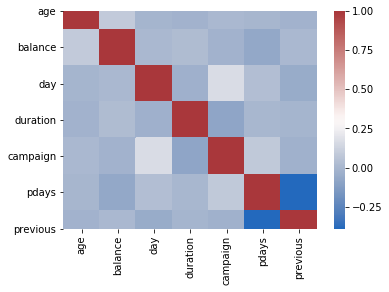

In [122]:
sns.heatmap(corr_mat, square=True, cmap='vlag')
pass

Как и предполагалось, никакой заметной корреляции увидеть не удаётся. Разве что между числом звонков в прошлый раз, и числом дней прошедших с прошлого звонка - 0/365 соответственно для многих клиентов. Эта связь была заведомо известна и никакой новой информации не даёт.

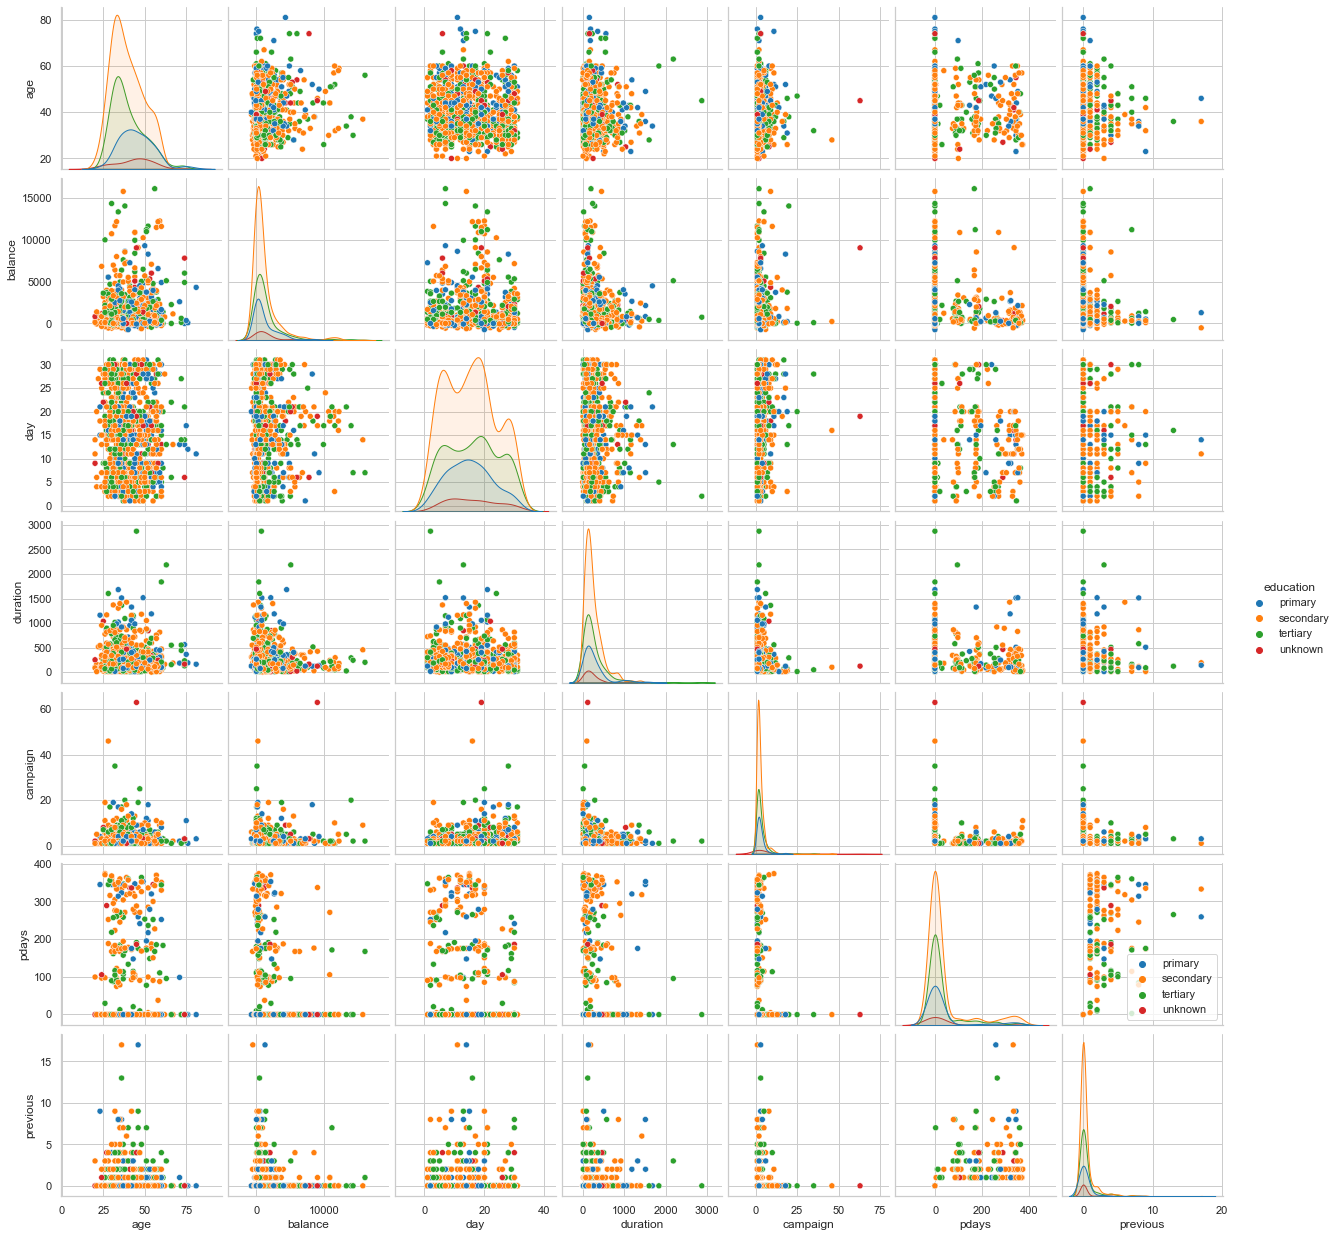

In [55]:
np.random.seed(21)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
sns.pairplot(data.iloc[random_subset], diag_kind = 'auto',hue='education',diag_kws={'alpha':0.1})
plt.legend()
pass

Из данных диаграмм не получается сделать каких-либо интересных выводов, послольку численные признаки между собой никак не связаны, а самая интересная пара возраст/баланс уже была рассмотрена внимательно ранее.

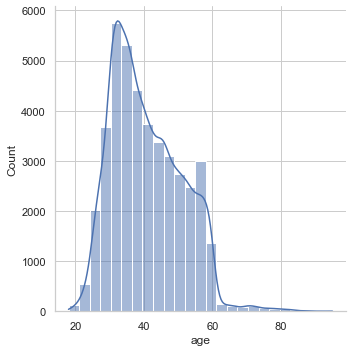

In [18]:
sns.displot(data['age'], bins=25,kde=True)
pass

Можно взглянуть на гистограмму возраста и увидеть предпочтения банка при обзвоне. Действительно, людям за 60 банк старается не звонить по вопросу вкладов. Также явно виден пик по возрасту, по-видимому предполагается, что люди около 30 более всего заинтересованы во вкладах.

<Figure size 1440x576 with 0 Axes>

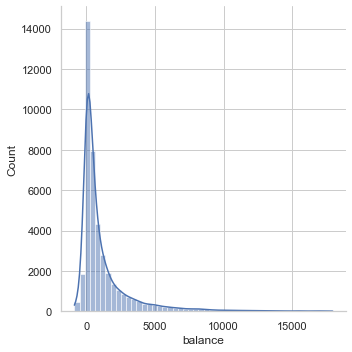

In [20]:
plt.figure(figsize = (20, 8))
sns.displot(data['balance'], bins=50,kde=True)
pass

Гистограмма баланса похожа на гамма-распределение по своему виду. Явно выделяется пик - у большинства клиентов, которым звонили, баланс на счёте нулевой.

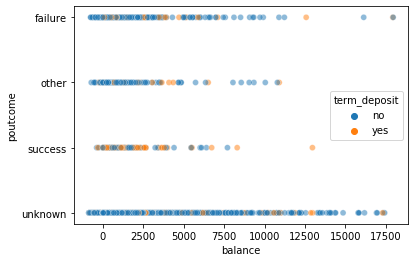

In [19]:
np.random.seed(21)
random_subset = np.random.choice(np.arange(data.shape[0]), size=5000, replace=False)
sns.scatterplot(x='balance', y='poutcome', hue = 'term_deposit', data=data.iloc[random_subset], alpha=0.5)
pass

На данной диаграмме заметна сильная связь между прошлым согласием и текущим согласием. Второй раз люди делают вклад охотнее.

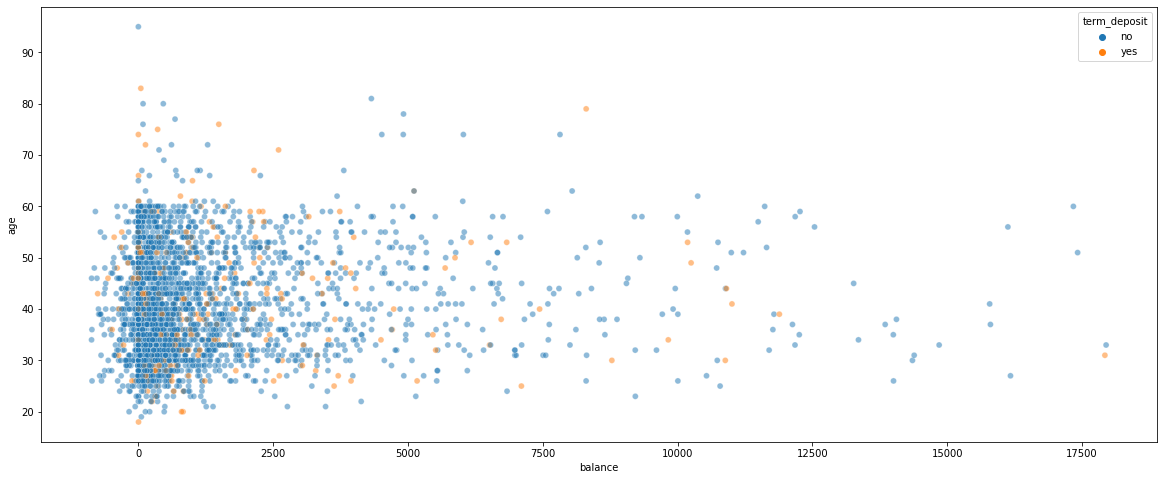

In [20]:
plt.figure(figsize = (20, 8))
np.random.seed(21)
random_subset = np.random.choice(np.arange(data.shape[0]), size=3000, replace=False)
sns.scatterplot(x='balance', y='age', hue = 'term_deposit', data=data.iloc[random_subset], alpha=0.5)
pass

На данной диаграмме на первый взгляд кажется, будто больше людей с меньшим балансом делают вклады, однако построив диаграмму другого вида, мы видим, что это не так.

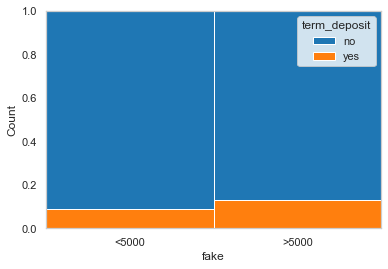

In [33]:
def wealthy (row):
    if (row['balance'] > 5000):
        return '>5000'
    else:
        return '<5000'
data_test = data
data_test['wealth'] = data.apply (lambda row: wealthy(row), axis=1)
sns.histplot(x='wealth',hue='term_deposit',data=data_test,multiple = 'fill',alpha = 1)
pass

На самом деле люди с большим количеством денег делают больше вкладов, что является вполне интуитивным выводом. На диаграмме рассеивания это видно хуже из-за вида распределения денег на счёте.

## 3. Обработка пропущенных значений

## 4. Обработка категориальных признаков

## 5. Обработка численных признаков

# Решение задачи классификации

## 6. Разбиение на обучающую и тестовую выборки

## 7. Классификатор kNN

## 8. Измерение метрик качества

# Выводы